<a href="https://colab.research.google.com/github/ywa136/TensorGraphicalModels.jl/blob/master/enkf_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiway Ensemble Kalman Filtering

## Introduction
For illustration of the **TensorGraphicalModel Julia package**, in this notebook we present examples applying various (inverse) covariance estimation algorithms to *Ensemble Kalman filter (EnKF)*, a method used for tracking dynamical systems and estimating the true state of a system from noisy observations. Specifically, we apply several (sparse and/or multiway) methods for the state (inverse) covariance estimation step of the EnKF

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.5.0" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools Plots MIRTjim https://github.com/ywa136/TensorGraphicalModels.jl"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=4
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Success! Please reload this page and jump to the next section."
fi

Installing Julia 1.5.0 on the current Colab Runtime...
2021-10-27 20:18:53 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.5/julia-1.5.0-linux-x86_64.tar.gz [105098627/105098627] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing Julia package Plots...
Installing Julia package MIRTjim...
Installing Julia package https://github.com/ywa136/TensorGraphicalModels.jl...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.5

Success! Please reload this page and jump to the next section.


In [1]:
versioninfo()

Julia Version 1.5.0
Commit 96786e22cc (2020-08-01 23:44 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, broadwell)
Environment:
  JULIA_NUM_THREADS = 4


## Generate ground truth data

We first generate simulated data from a linear Gaussian state space model. Here, two major types of dynamical structures are implemented in the package: *convection_diffusion* for states generated by solving the Convection Diffusion equation and *poisson* for states generated by solving the time-invariant Poisson equation; three types of observation sturctures are implemented: *identity*, *linear_perm*, and *linear_perm_miss*, which amounts to observations subject to: only additive random noise, random permutation of the state variale plus additive noise, and random permutation of partially observed state variable plus noise, respectively.

In [3]:
using TensorGraphicalModels

In [4]:
dynamic_type = "convection_diffusion" #specify the dynamical model: convection_diffusion, poisson, or poisson_ar
obs_type = "linear_perm_miss" #specify the observation model: identity, linear_perm, or linear_perm_miss
T = 20 #time stamps
N = 50 #number of ensembles
px = py = (32, 32) #state dimension
obs_noise = 0.01
process_noise = 0.01
add_process_noise = false
X, Y, H = TensorGraphicalModels.gen_kalmanfilter_data(dynamic_type, obs_type, T, px, py, obs_noise, process_noise, add_process_noise)

([3.815344909358524 1.5623474351695643 … 0.003294254576811098 0.0029592237945764966; 3.679326205895566 1.941533005783738 … 0.006463085791385372 0.005815725879892775; … ; 0.004579154599009663 -0.47532618427673656 … 0.0022587982239995153 0.0020273033190452453; -4.491362164974706 -1.1221520040708177 … 0.0011971617812786615 0.0010756317581720565], [-0.3087866242494743 -0.03332176437938603 … -0.005687424751754717 -0.005512310635862286; -0.7766508767159481 -0.10512068830554513 … 0.010548261967048812 -0.006383896227239799; … ; 0.23019337876139281 0.13761334430407374 … 0.05139633593729383 0.04955226860058727; 0.43299116697385265 0.43777726798851185 … 0.01620434724311641 0.011086912815103657], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

### Visualize the true process

In [5]:
using Plots
using MIRTjim

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1278
┌ Info: Saved animation to 
│   fn = /content/tmp.gif
└ @ Plots /root/.julia/packages/Plots/T6yvp/src/animation.jl:114


Plots.AnimatedGif("/content/tmp.gif")
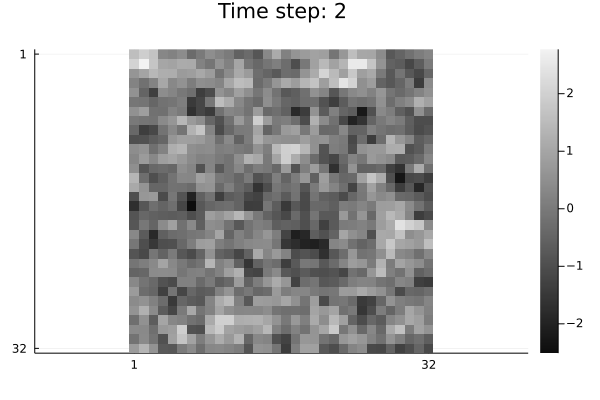

In [6]:
# gif all time steps
anim_x = @animate for i=2:(T+1)
    # plot(jim(reshape(X[:,i],px),clim=(-3.0,3.0)),
    #     title=string("Time step: ",i))
    Plots.plot(jim(reshape(X[:,i],px)),
        title=string("Time step: ",i))
end
gif(anim_x, fps=5)

## Run EnKF with tensor graphical models

To estimate the high-dimensional state (inverse) covariance matrix of an EnKF. Any (sparse and/or multiway) estimator could be used. Here, we compare the performance of *Glasso*, *KPCA*, *KGlasso*, *Teralasso*, and *SyGlasso*.

In [ ]:
method_list = ["glasso", "kpca", "kglasso", "teralasso", "sg_palm"]
NRMSEs_list = []
time_list = []
Omegahat_list = []
for method in method_list
    starttime = time()
    ## run enkf 
    Xhat, Xhat_bar, Omegahat = enkf(Y, 
                            TensorGraphicalModels.method_str_to_type(method),
                            dynamic_type,
                            H,
                            px,
                            py,
                            N,
                            obs_noise, 
                            process_noise,
                            add_process_noise)
    ## timer
    stoptime = time() - starttime
    push!(time_list, stoptime)
    ## compute NRMSEs
    NRMSEs = TensorGraphicalModels.compute_nrmse(X, Xhat)
    push!(NRMSEs_list, NRMSEs)
    ## store est. precision/cov matrix
    push!(Omegahat_list, Omegahat)
end

### Plot RMSEs for estimated ensembles


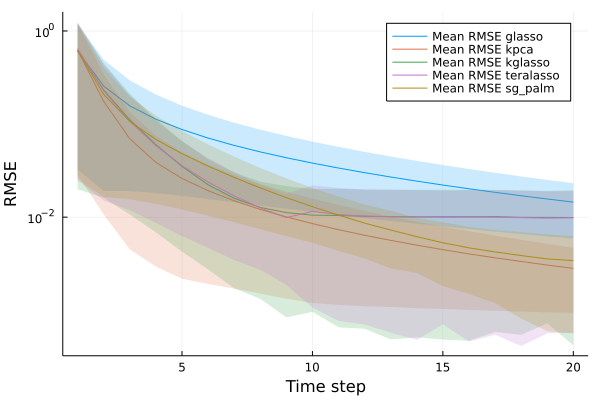

In [8]:
fig = Plots.plot()
xlabel!("Time step")
ylabel!("RMSE")
for method in method_list
    if method == "sg_palm"
        NRMSEs = NRMSEs_list[end] 
    elseif method == "teralasso"
        NRMSEs = NRMSEs_list[4] 
    elseif method == "kglasso"
        NRMSEs = NRMSEs_list[3] 
    elseif method == "glasso"
        NRMSEs = NRMSEs_list[1] 
    elseif method == "kpca"
        NRMSEs = NRMSEs_list[2] 
    end
    ## plot rmse progression for each method
    TensorGraphicalModels.plot_nrmse!(NRMSEs, method)
end
display(fig)